In [2]:
import torch
import torchvision
from torchvision import transforms
from skimage import io, transform
from torch import nn

import json

import numpy as np

from training.losses import *
from training.train import *
from training.plots import *
from models.gan import *
from models.classifier import *
from training.data import *

import matplotlib.pyplot as plt
from PIL import Image

In [2]:
BATCH_SIZE = 128
LR = 3e-4
BETAS = 0.9, 0.999

In [3]:
data = FacesDataset("./../data/vgg_data/", transform=lambda x: (torch.tensor(transform.resize(np.array(x['image']), (48, 48))).permute((2, 0, 1)), x['class']))
train_data = torch.utils.data.DataLoader(data, batch_size=BATCH_SIZE, drop_last=True)

./../data/vgg_data/Bingbing_Fan\794.jpg
./../data/vgg_data/Andrew_Buchan\295.jpg
./../data/vgg_data/Thad_Luckinbill\405.jpg
./../data/vgg_data/Nelly\757.jpg


In [4]:
for batch in train_data:
    print(0)
    print(batch)
    print(batch[0].shape)
    break

0
[tensor([[[[0.2696, 0.0971, 0.0304,  ..., 0.0176, 0.0284, 0.1402],
          [0.2696, 0.0951, 0.0284,  ..., 0.0216, 0.0275, 0.0843],
          [0.2392, 0.0882, 0.0333,  ..., 0.0157, 0.0392, 0.0931],
          ...,
          [0.4627, 0.4627, 0.4931,  ..., 0.1343, 0.1235, 0.0971],
          [0.4549, 0.4559, 0.4873,  ..., 0.1794, 0.1039, 0.0892],
          [0.4627, 0.4637, 0.4853,  ..., 0.3990, 0.1098, 0.0873]],

         [[0.2235, 0.0627, 0.0137,  ..., 0.0206, 0.0206, 0.1167],
          [0.2265, 0.0637, 0.0127,  ..., 0.0255, 0.0196, 0.0618],
          [0.1990, 0.0598, 0.0186,  ..., 0.0147, 0.0324, 0.0755],
          ...,
          [0.4265, 0.4157, 0.4392,  ..., 0.1127, 0.1176, 0.1127],
          [0.4020, 0.3941, 0.4206,  ..., 0.1627, 0.1078, 0.1225],
          [0.3931, 0.3912, 0.4069,  ..., 0.3902, 0.1206, 0.1324]],

         [[0.2000, 0.0529, 0.0049,  ..., 0.0324, 0.0118, 0.0990],
          [0.2029, 0.0520, 0.0039,  ..., 0.0294, 0.0127, 0.0451],
          [0.1745, 0.0441, 0.0039,  ...

In [5]:
base_classifier = SimpleClassifier(in_channels=3, image_size=48, num_classes=51)

In [6]:
optimizer = torch.optim.Adam(base_classifier.parameters(), lr=LR, betas=BETAS)
criterion = nn.CrossEntropyLoss()

In [7]:
base_classifier_trainer = BaseClassifierTrainer(base_classifier, criterion, optimizer, 'cpu')

In [13]:
base_res = base_classifier_trainer.train(train_data, 5)

Epoch: 0, Loss: 3.0785147723647466
Epoch: 1, Loss: 2.270444853190283
Epoch: 2, Loss: 1.9863585905881704
Epoch: 3, Loss: 1.8108895512929573
Epoch: 4, Loss: 1.6749636039859923


In [14]:
# data = torchvision.datasets.MNIST("./../data/mnist", download=True, train=False, transform=lambda x: torch.tensor(transform.resize(np.array(x), (10, 10))).unsqueeze(0))
# train_data = torch.utils.data.DataLoader(data, batch_size=BATCH_SIZE, drop_last=True)

In [15]:
generator_model = Generator(in_channels=3, out_channels=3)
discriminator_model = Discriminator(in_channels=3, image_size=48)
attacked_model = base_classifier.eval()

In [16]:
generator_optimizer = torch.optim.Adam(generator_model.parameters(), lr=LR, betas=BETAS)
discriminator_optimizer = torch.optim.Adam(discriminator_model.parameters(), lr=LR, betas=BETAS)

In [17]:
trainer = Trainer(generator_model, discriminator_model, attacked_model,
                  GANLoss(BATCH_SIZE, 'cpu'),
                  AttackLoss(attacked_model, 'cpu'),
                  HingeLoss(attacked_model, BATCH_SIZE, 'cpu'),
                  discriminator_optimizer, generator_optimizer, 'cpu')

In [18]:
res = trainer.train(train_data, 5)

KeyboardInterrupt: 

In [19]:
val_batch = iter(train_data).next()
for i in range(16):
    print(F.softmax(attacked_model(val_batch[0].float()), -1).cpu().detach().numpy()[i, val_batch[1][i]], F.softmax(attacked_model(val_batch[0].float() + generator_model(val_batch[0].float())), -1).cpu().detach().numpy()[i, val_batch[1][i]])
    print(val_batch[1][i])

0.73071116 0.00069232355
tensor(35)
0.07303468 0.004350687
tensor(1)
0.10981087 0.006639615
tensor(24)
0.51980984 0.0007606941
tensor(45)
0.52565295 3.2145433e-06
tensor(43)
0.0046192626 0.00011197415
tensor(12)
0.10771791 0.009881951
tensor(13)
0.39592317 0.08411043
tensor(44)
0.65253955 0.020222953
tensor(2)
0.034099698 0.002457294
tensor(33)
0.36903393 0.0568663
tensor(44)
0.023842378 0.0047578523
tensor(28)
0.49975497 0.0006171475
tensor(48)
0.85261357 0.00035540308
tensor(26)
0.091961354 0.9436447
tensor(10)
0.6203308 0.15613921
tensor(36)


Text(0.5, 1.0, 'Fake: Prediction: 10, confidence: 0.4021652936935425')

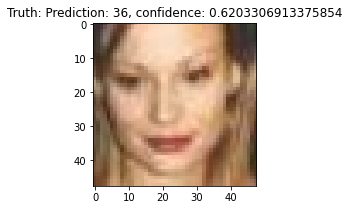

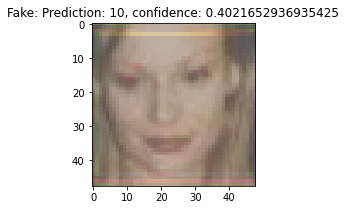

In [21]:
test_img = val_batch[0].float()[15:16]
true_confs = F.softmax(attacked_model(test_img), -1).cpu().detach().numpy()[0]
fake_confs = F.softmax(attacked_model(test_img + generator_model(test_img)), -1).cpu().detach().numpy()[0]

plt.figure(figsize=(3,3))
plt.imshow(test_img[0].permute((1, 2, 0)), cmap='gray')
plt.title("Truth: Prediction: {}, confidence: {}".format(np.argmax(true_confs), true_confs.max()))

plt.figure(figsize=(3,3))
plt.imshow(((test_img + generator_model(test_img).cpu().detach().numpy()) / 2)[0].permute((1, 2, 0)), cmap='gray')
plt.title("Fake: Prediction: {}, confidence: {}".format(np.argmax(fake_confs), fake_confs.max()))

NameError: name 'res' is not defined

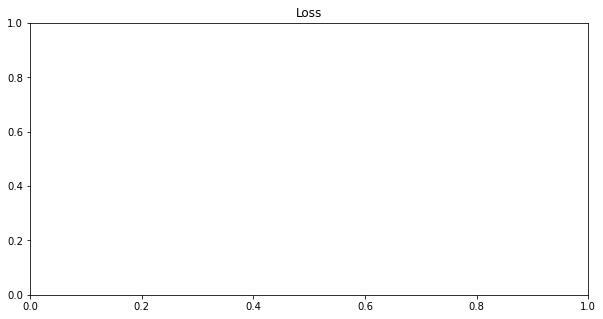

In [22]:
plt.figure(figsize=(10,5))
plt.title("Loss")
plt.plot(res[0],label="Generator loss")
plt.plot(res[1],label="Discriminator loss")
plt.plot(res[2],label="Attack loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()